In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

Q1-1. 

Implement the algorithm for the MED and MMD classifiers on the training set of the MNIST
dataset. Determine the decision boundary for the two classifiers. Plot the boundary along with the
training data.

In [46]:
# Load the MNIST dataset, False makes it return the data as a NumPy array 
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')

# Flatten the images
X = mnist.data
y = mnist.target
#print(X.shape) #(70000, 784)

# Split the data 
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

# Filter data for classes 3 and 4
mask_train = np.isin(y_train, ['3', '4'])
X_train, y_train = X_train[mask_train], y_train[mask_train]
mask_test = np.isin(y_test, ['3', '4'])
X_test, y_test = X_test[mask_test], y_test[mask_test]

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [47]:
# Use PCA to convert the 11973x784 vectors to 11973x2 vectors
pca_train_2 = PCA(n_components=2)
X_pca_train_2 = pca_train_2.fit_transform(X_train) #print(X_pca.shape) = (11973, 2)
X_pca_test_2 = pca_train_2.fit_transform(X_test)
print(X_pca_train_2.shape)
print(y_train.shape)
print(X_pca_test_2.shape)
print(y_test.shape)


(11973, 2)
(11973,)
(1992, 2)
(1992,)


Mean-Euclidean Distance (MED) classifier

In [48]:
# Define the MED classifier
def med_classifier(X_pca_train, y_train):
    mask_3 = y_train == 3
    mask_4 = y_train == 4
    X_pca_3 = X_pca_train[mask_3]
    X_pca_4 = X_pca_train[mask_4]
    mean_3 = np.mean(X_pca_3, axis=0) #[653.5810747   31.41154154]
    mean_4 = np.mean(X_pca_4, axis=0) #[-683.94232919  -32.87072364]

    y_pred_med = []
    # Compute Euclidean distances
    for x in X_pca_train:
        dist_3 = ((x - mean_3)**2).sum()**0.5
        dist_4 = ((x - mean_4)**2).sum()**0.5

        if dist_3 < dist_4:
            y_pred_med.append(3)
        else:
            y_pred_med.append(4)
    
    return np.array(y_pred_med), mean_3, mean_4

# Classify training data
y_pred_med, mean_3, mean_4 = med_classifier(X_pca_train_2, y_train)
# Classify testing data
y_pred_med, mean_3, mean_4 = med_classifier(X_pca_test_2, y_test)

Mean-Mahalanobis Distance (MMD) classifier

In [49]:
def matrix_inverse(matrix):
    # Calculate the determinant of the matrix
    determinant = np.linalg.det(matrix)
    
    # Check if the matrix is invertible
    if determinant == 0:
        raise ValueError("The matrix is not invertible.")
    
    # Calculate the adjugate of the matrix
    adjugate = np.zeros(matrix.shape)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            minor = np.delete(np.delete(matrix, i, axis=0), j, axis=1)
            adjugate[j, i] = ((-1) ** (i + j)) * np.linalg.det(minor)
    
    # Calculate the inverse of the matrix
    inverse_matrix = adjugate / determinant
    
    return inverse_matrix

# Define the MMD classifier
def mmd_classifier(X_pca_train, y_train):
    mask_3 = y_train == 3
    mask_4 = y_train == 4
    X_pca_3 = X_pca_train[mask_3]
    X_pca_4 = X_pca_train[mask_4]
    mean_3 = np.mean(X_pca_3, axis=0) #[653.5810747   31.41154154]
    mean_4 = np.mean(X_pca_4, axis=0) #[-683.94232919  -32.87072364]
    cov_3 = np.cov(X_pca_3, rowvar=False)
    cov_4 = np.cov(X_pca_4, rowvar=False)
    inv_cov_3 = matrix_inverse(cov_3)
    inv_cov_4 = matrix_inverse(cov_4)

    y_pred_mmd = []
    # Compute Mahalanobis distances
    for x in X_pca_train:
        dist_3 = ((x - mean_3).T @ inv_cov_3 @ (x - mean_3))**0.5
        dist_4 = ((x - mean_4).T @ inv_cov_4 @ (x - mean_4))**0.5

        if dist_3 < dist_4:
            y_pred_mmd.append(3)
        else:
            y_pred_mmd.append(4)
    
    return np.array(y_pred_mmd), mean_3, mean_4, inv_cov_3, inv_cov_4

# Classify training data
y_pred_mmd, mean_3, mean_4, inv_cov_3, inv_cov_4 = mmd_classifier(X_pca_train_2, y_train)
y_pred_mmd, mean_3, mean_4, inv_cov_3, inv_cov_4 = mmd_classifier(X_pca_test_2, y_test)


Plot MED classifier and boundary

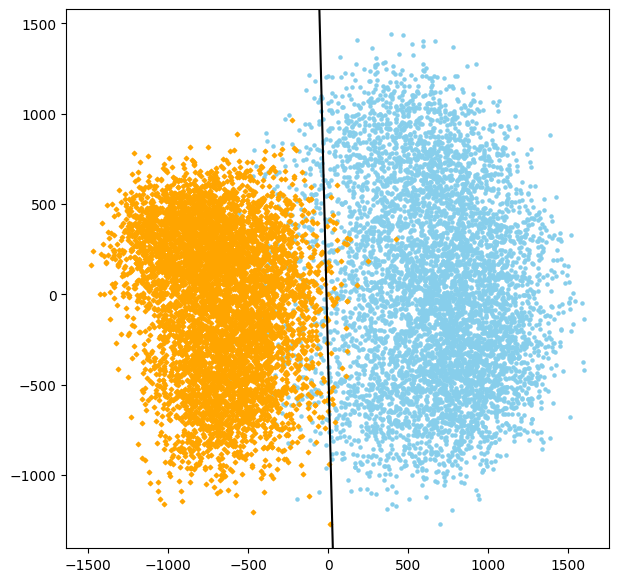

In [50]:
f, ax = plt.subplots(figsize=(7, 7))
c1, c2 = "#87CEEB", "#FFA500"
ax.scatter(*X_pca_train_2[y_train==3].T, c=c1, s=5)
ax.scatter(*X_pca_train_2[y_train==4].T, c=c2, marker="D", s=5)
x_vec = np.linspace(*ax.get_xlim())
y_vec = np.linspace(*ax.get_ylim())
xx, yy = np.meshgrid(x_vec, y_vec)

# Define the decision boundary function
def decision_boundary_med(x_vec, mean_3, mean_4):
    return np.array([(mean_4 - mean_3).dot(x) + 0.5 * (mean_3.dot(mean_3) - mean_4.dot(mean_4)) for x in x_vec])

Z = decision_boundary_med(np.c_[xx.ravel(), yy.ravel()], mean_3, mean_4)
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], cmap="Greys_r")
#plt.savefig("MED_boundary.png")
plt.show()

Plot MMD classifier and boundary

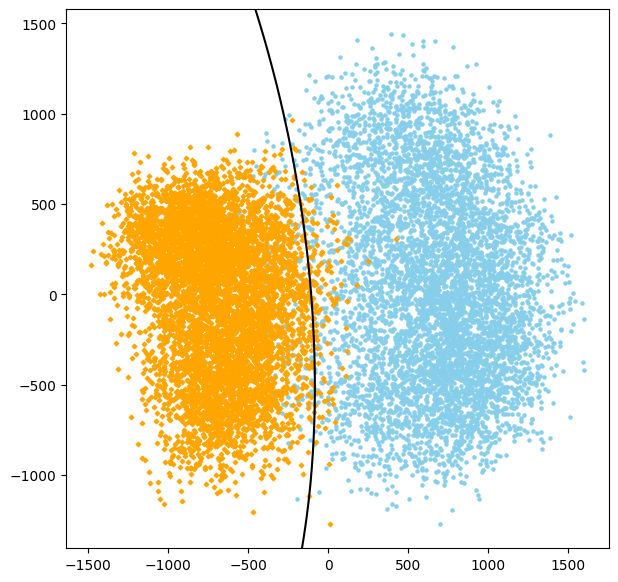

In [51]:
f, ax = plt.subplots(figsize=(7, 7))
c1, c2 = "#87CEEB", "#FFA500"
ax.scatter(*X_pca_train_2[y_train==3].T, c=c1, s=5)
ax.scatter(*X_pca_train_2[y_train==4].T, c=c2, marker="D", s=5)
x_vec = np.linspace(*ax.get_xlim())
y_vec = np.linspace(*ax.get_ylim())
xx, yy = np.meshgrid(x_vec, y_vec)

# Define the decision boundary function for MMD
def decision_boundary_mmd(x_vec, mean_3, mean_4, inv_cov_3, inv_cov_4):
    return np.array([((x - mean_4).T @ inv_cov_4 @ (x - mean_4)) - ((x - mean_3).T @ inv_cov_3 @ (x - mean_3)) for x in x_vec])

Z_mmd = decision_boundary_mmd(np.c_[xx.ravel(), yy.ravel()], mean_3, mean_4, inv_cov_3, inv_cov_4)
Z_mmd = Z_mmd.reshape(xx.shape)
ax.contour(xx, yy, Z_mmd, levels=[0], cmap="Greys_r")
plt.show()

Q1_2: 

Use the test set of the two classes in the MNIST dataset and make label predictions for all the
test vectors for the two classes using the MED and MMD classifiers. Report the classification accuracy
of the classifiers using:

In [52]:
error_rate_med_test = np.sum(y_pred_med == y_test) / len(y_test)
print("accuracy_med_test: ", error_rate_med_test)
error_rate_mmd_test = np.sum(y_pred_mmd == y_test) / len(y_test)
print("accuracy_mmd_test: ", error_rate_mmd_test)

error_med_test:  0.9764056224899599
error_mmd_test:  0.9819277108433735


Q1_3  

Which of the two classifiers is better? Explain.

The MMD classifier, which considers the covariance of the data, can better handle the high dimensionality and reduce the sensitivity to outliers. Also, the MNIST data contains some noise and outliers, so the MMD classifier performs higher accuracy than the MED classifier, which only considers the mean.

Q1_4 

Now, for the same two classes in the MNIST dataset, use PCA to convert the images to 20×1
vectors. Repeat steps 1-3 for this dataset. For step 1, can you plot the decision boundary for this dataset?
Explain.

In [56]:
# Use PCA to convert the 13965x784 vectors to 13965x20 vectors
pca_train_20 = PCA(n_components=20)
X_pca_train_20 = pca_train_20.fit_transform(X_train) #print(X_pca.shape) = (11973, 20)
X_pca_test_20 = pca_train_20.fit_transform(X_test)
# print(X_pca_train_20.shape)
# print(y_train.shape)
# print(X_pca_test_20.shape)
# print(y_test.shape)

# Mean-Euclidean Distance (MED) classifier
# Define the MED classifier
def med_classifier(X_pca_train, y_train):
    mask_3 = y_train == 3
    mask_4 = y_train == 4
    X_pca_3 = X_pca_train[mask_3]
    X_pca_4 = X_pca_train[mask_4]
    mean_3 = np.mean(X_pca_3, axis=0) #[653.5810747   31.41154154]
    mean_4 = np.mean(X_pca_4, axis=0) #[-683.94232919  -32.87072364]

    y_pred_med = []
    # Compute Euclidean distances
    for x in X_pca_train:
        dist_3 = ((x - mean_3)**2).sum()**0.5
        dist_4 = ((x - mean_4)**2).sum()**0.5

        if dist_3 < dist_4:
            y_pred_med.append(3)
        else:
            y_pred_med.append(4)
    
    return np.array(y_pred_med), mean_3, mean_4

# Classify training data
y_pred_med, mean_3, mean_4 = med_classifier(X_pca_train_20, y_train)
y_pred_med, mean_3, mean_4 = med_classifier(X_pca_test_20, y_test)

error_rate_med_test = np.sum(y_pred_med == y_test) / len(y_test)
print("error_med_test: ", error_rate_med_test)

# Mean-Mahalanobis Distance (MMD) classifier

# Define the MMD classifier
def mmd_classifier(X_pca_train, y_train):
    mask_3 = y_train == 3
    mask_4 = y_train == 4
    X_pca_3 = X_pca_train[mask_3]
    X_pca_4 = X_pca_train[mask_4]
    mean_3 = np.mean(X_pca_3, axis=0) #[653.5810747   31.41154154]
    mean_4 = np.mean(X_pca_4, axis=0) #[-683.94232919  -32.87072364]
    cov_3 = np.cov(X_pca_3, rowvar=False)
    cov_4 = np.cov(X_pca_4, rowvar=False)
    inv_cov_3 = matrix_inverse(cov_3)
    inv_cov_4 = matrix_inverse(cov_4)

    y_pred_mmd = []
    # Compute Mahalanobis distances
    for x in X_pca_train:
        dist_3 = ((x - mean_3).T @ inv_cov_3 @ (x - mean_3))**0.5
        dist_4 = ((x - mean_4).T @ inv_cov_4 @ (x - mean_4))**0.5

        if dist_3 < dist_4:
            y_pred_mmd.append(3)
        else:
            y_pred_mmd.append(4)
    
    return np.array(y_pred_mmd), mean_3, mean_4, inv_cov_3, inv_cov_4

# Classify training data
y_pred_mmd, mean_3, mean_4, inv_cov_3, inv_cov_4 = mmd_classifier(X_pca_train_20, y_train)
y_pred_mmd, mean_3, mean_4, inv_cov_3, inv_cov_4 = mmd_classifier(X_pca_test_20, y_test)

error_rate_mmd_test = np.sum(y_pred_mmd == y_test) / len(y_test)
print("error_mmd_test: ", error_rate_mmd_test)

error_med_test:  0.981425702811245
error_mmd_test:  0.9979919678714859


It is not feasible to visualize a decision boundary when working with a dataset that has 20 dimensions. Typically, a decision boundary is plotted in two or three dimensions.